# SWOT Date/Time Transformation

Authored by Nicholas Tarpinian, *PO.DAAC*

## Summary

The following workflow lets you create time series plots with various Geographical Information System (GIS) Desktop softwares by transforming SWOT_L2_HR_RiverSP_2.0 Shapefile vector datasets.

------

## Requirements

### 1. Compute environment

- **Local compute environment** e.g. laptop, server: this tutorial can be run on your local machine.

### 2. Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

------

### Learning Objectives:
- Accessing SWOT shapefile hydrology dataset through earthaccess and downloading it locally.
- Utilizing geoprocessing tools with GIS Desktop Softwares; ArcGIS Pro and QGIS.
- Transforming 'time_str' attribute/variable to a Date/Time data type.   
- Utilizing the new data type variable to create a time series plot/chart.

------

### Import libraries

In [ ]:
import os
import glob 
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import zipfile
import earthaccess
from earthaccess import Auth, DataCollections, DataGranules, Store

## Authentication with earthaccess

In this notebook, we will be calling the authentication in the below cell.

In [ ]:
auth = earthaccess.login()

### Search using `earthaccess` for SWOT River Reaches

Each dataset has it's own unique collection concept ID. For this dataset it is SWOT_L2_HR_RiverSP_2.0. SWOT files come in "reach" and "node" versions in this same collection, here we want the 10km reaches rather than the nodes. We will also only get files for North America, or 'NA'. 

In [ ]:
results = earthaccess.search_data(short_name = 'SWOT_L2_HR_RIVERSP_2.0', 
                                  temporal = ('2024-01-01 00:00:00', '2024-01-31 23:59:59'), # can also specify by time
                                  granule_name = '*Reach*_NA_*') # here we filter by Reach files (not node), continent code=NA

### Download the Data into a folder

In [ ]:
earthaccess.download(results, "../datasets/data_downloads/SWOT_files")

### Unzip shapefiles to existing folder

In [ ]:
folder = Path("../datasets/data_downloads/SWOT_files")
for item in os.listdir(folder): # loop through items in dir
    if item.endswith(".zip"): # check for ".zip" extension
        zip_ref = zipfile.ZipFile(f"{folder}/{item}") # create zipfile object
        zip_ref.extractall(folder) # extract file to dir
        zip_ref.close() # close file

### Merging multiple reaches to a single shapefile

Since a time series plot will be created, merging all the shapefiles to one will be the better option.

In [ ]:
# State filename extension to look for within folder, in this case .shp which is the shapefile
shapefiles = folder.glob("*.shp")

# Merge/Combine multiple shapefiles in folder into one
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)

# Export merged geodataframe into shapefile
gdf.to_file(folder / 'SWOTReaches.shp')

## ArcGIS Pro

Esri's ArcGIS Pro offers a geoproccesing tool called 'Convert Time Field'. 

This allows the transformation of date and time values to be created from one field to another. 

In this case the date/time field 'time_str' is in a text data type format. It needs to be converted to a date/time data type in order to create a time series plot.

The ‘no_data’ values do not get converted; it keeps it as ‘NULL’

<nop/> <div style="width: 500px;">![arcpro_datetime_1.png](../../images/swot_datetime/arcpro_datetime_1.png)</div>
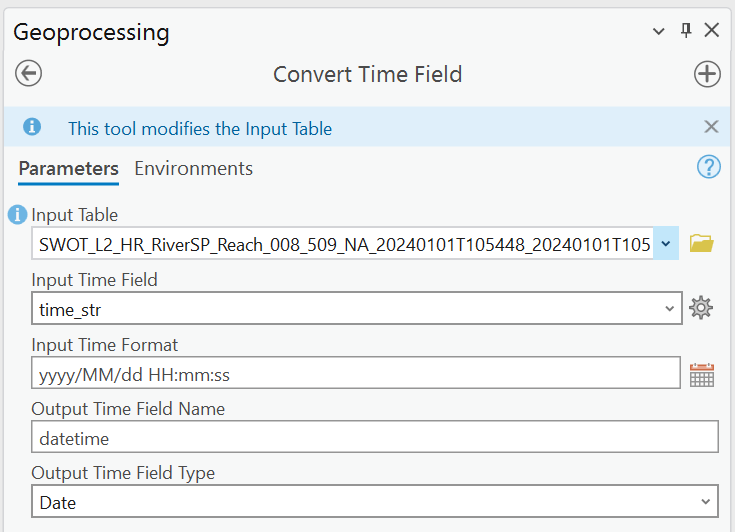

Once the new field is created, this allows for the creation of a time series plot.

This is a great way to observe an area with multiple days of measurements.

In this case, we will configure a line plot in the chart properties of the median of water surface elevation 'wse'.

<nop/> <div style="width: 250px;">![arcpro_datetime_2.png](../../images/swot_datetime/arcpro_datetime_2.png)</div>

<nop/> <div style="width: 1100px;">![arcpro_datetime_3.png](../../images/swot_datetime/arcpro_datetime_3.png)</div>
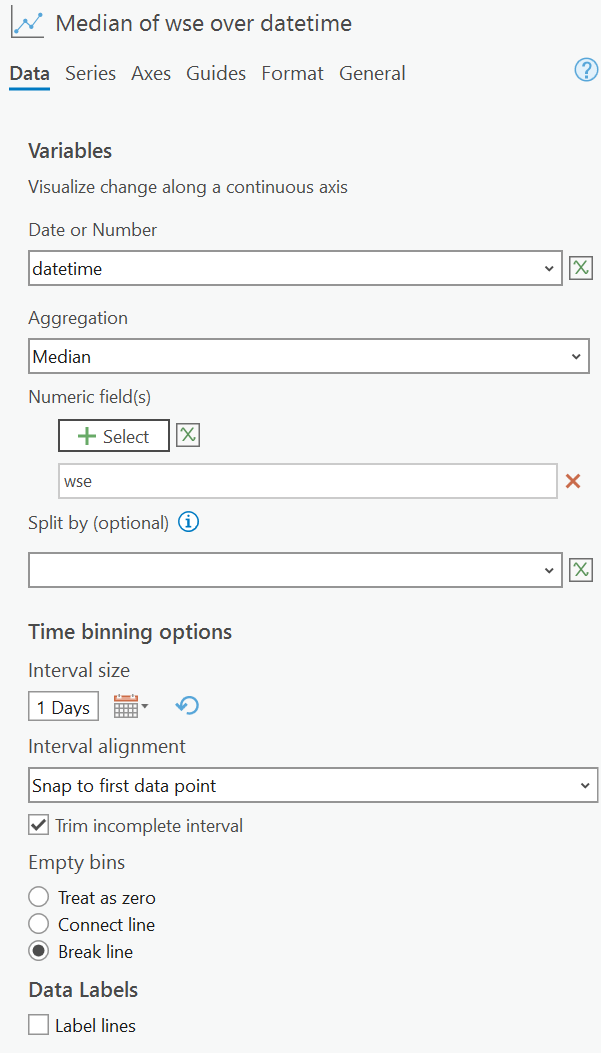
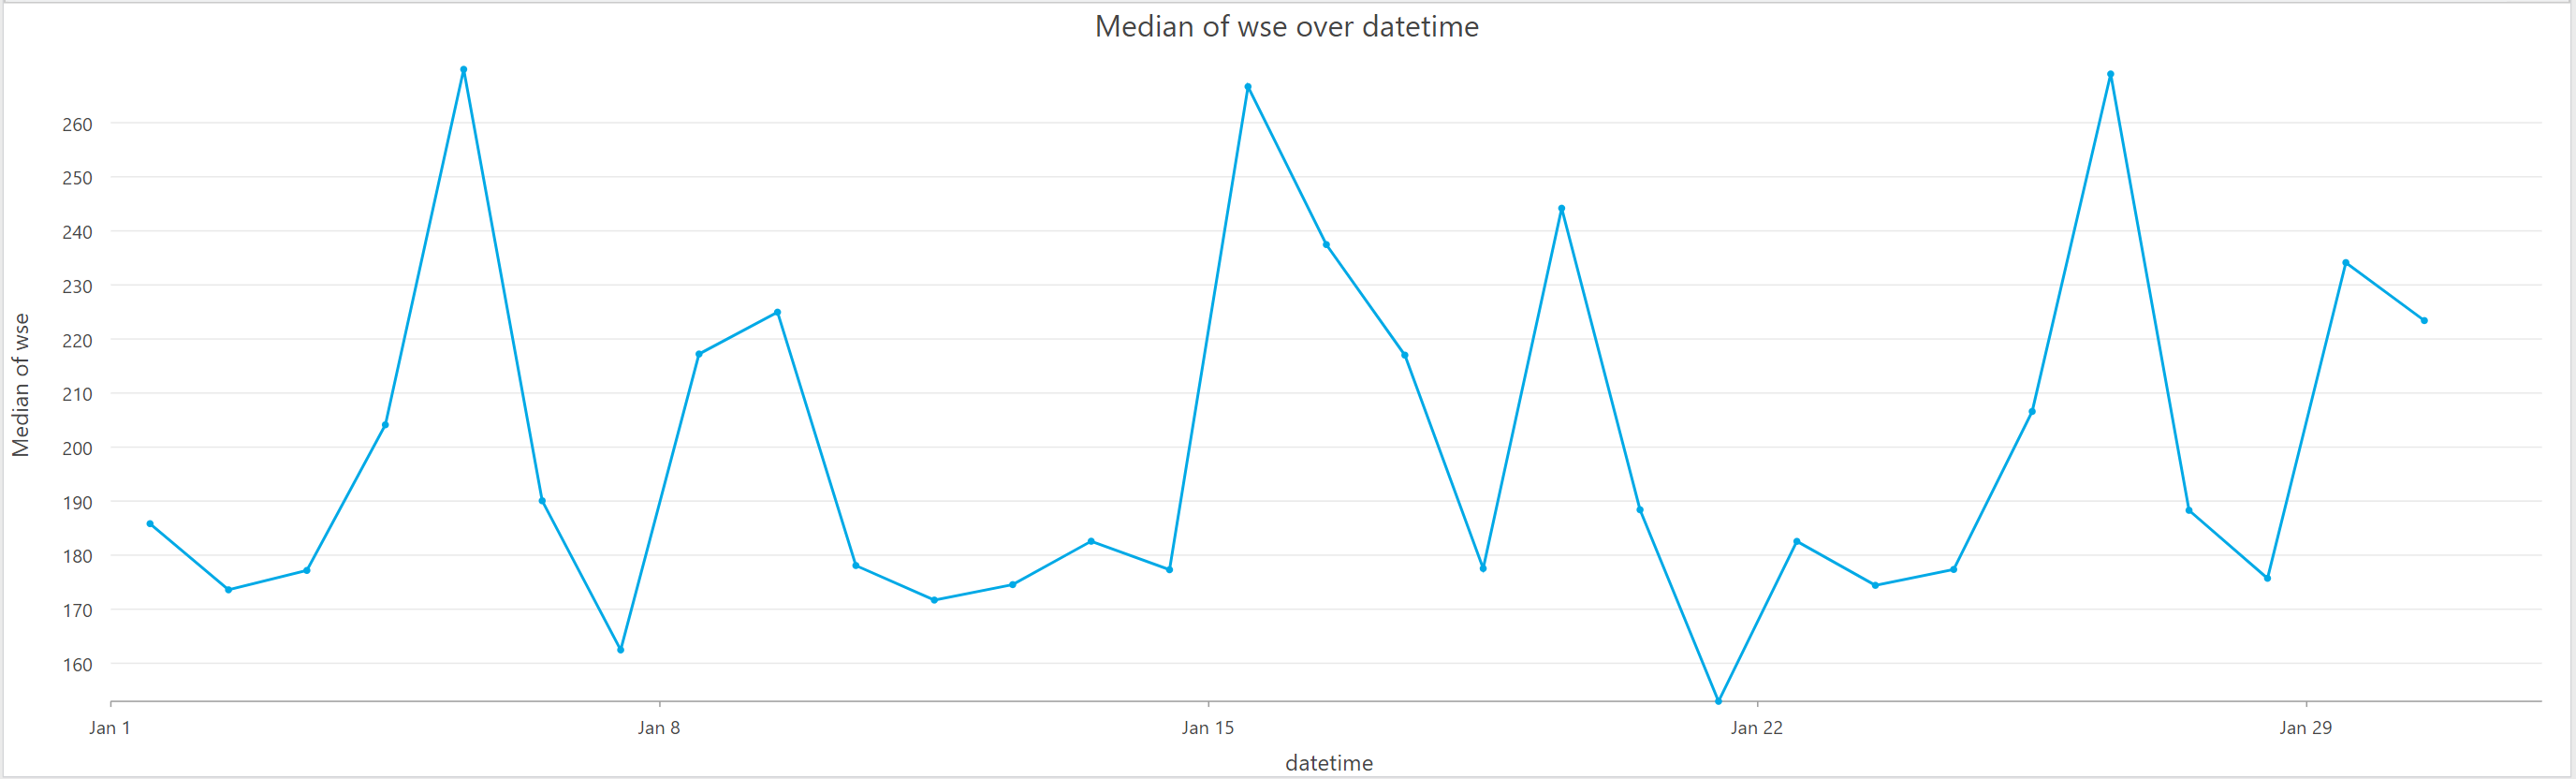

## QGIS

QGIS offers a geoproccesing tool called 'Refactor Fields'. 

This modifies the date/time values of the current field and creates a new layer.

In this case the date/time field 'time_str' can be changed to a date/time data type.

<nop/> <div style="width: 700px;">![qgis_datetime_1.png](../../images/swot_datetime/qgis_datetime_1.png)</div>

In the 'type' section, you can select the data type of your choosing but for this case we will select 'Date & Time'.

The new layer can be saved to memory as a temporary layer, but its best to save the layer locally.

<nop/> <div style="width: 700px;">![qgis_datetime_2.png](../../images/swot_datetime/qgis_datetime_2.png)</div>
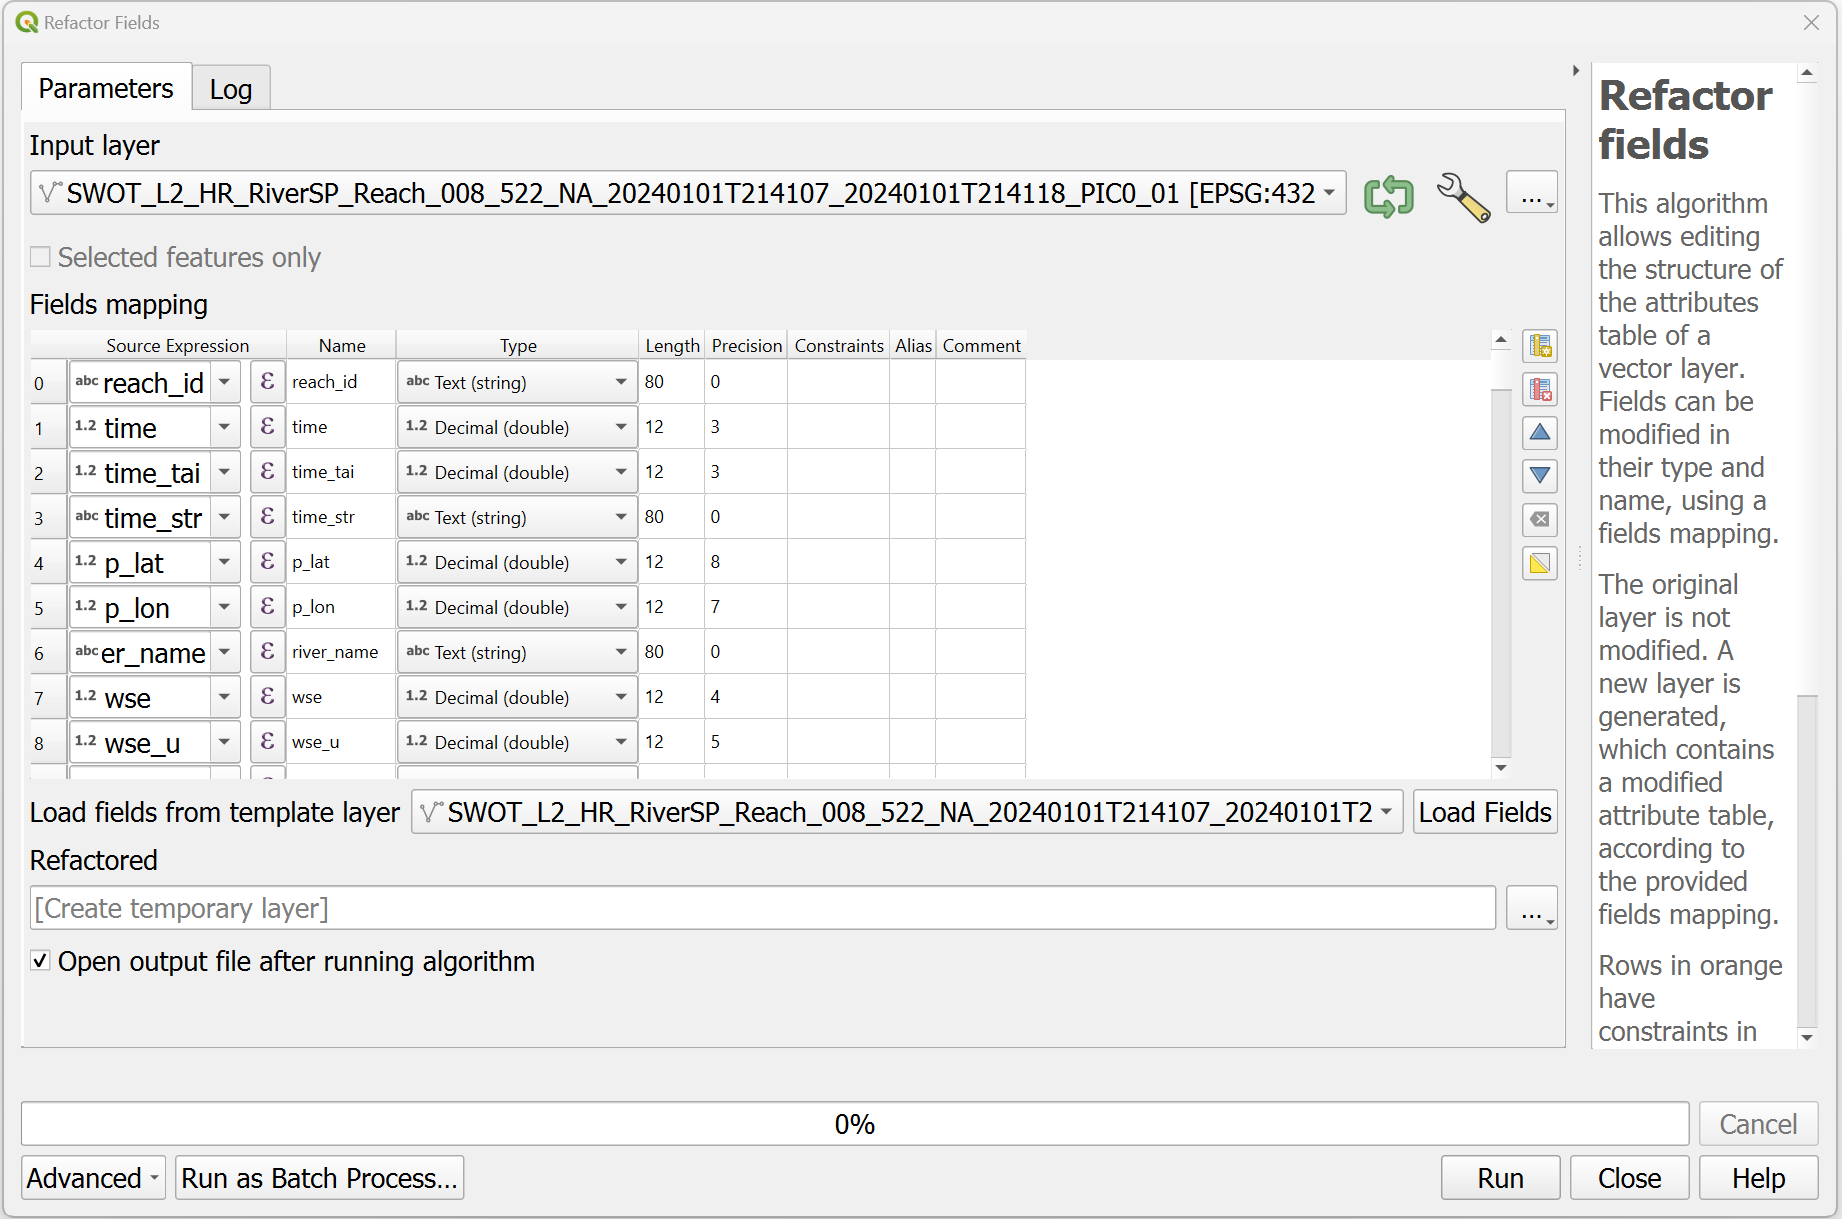
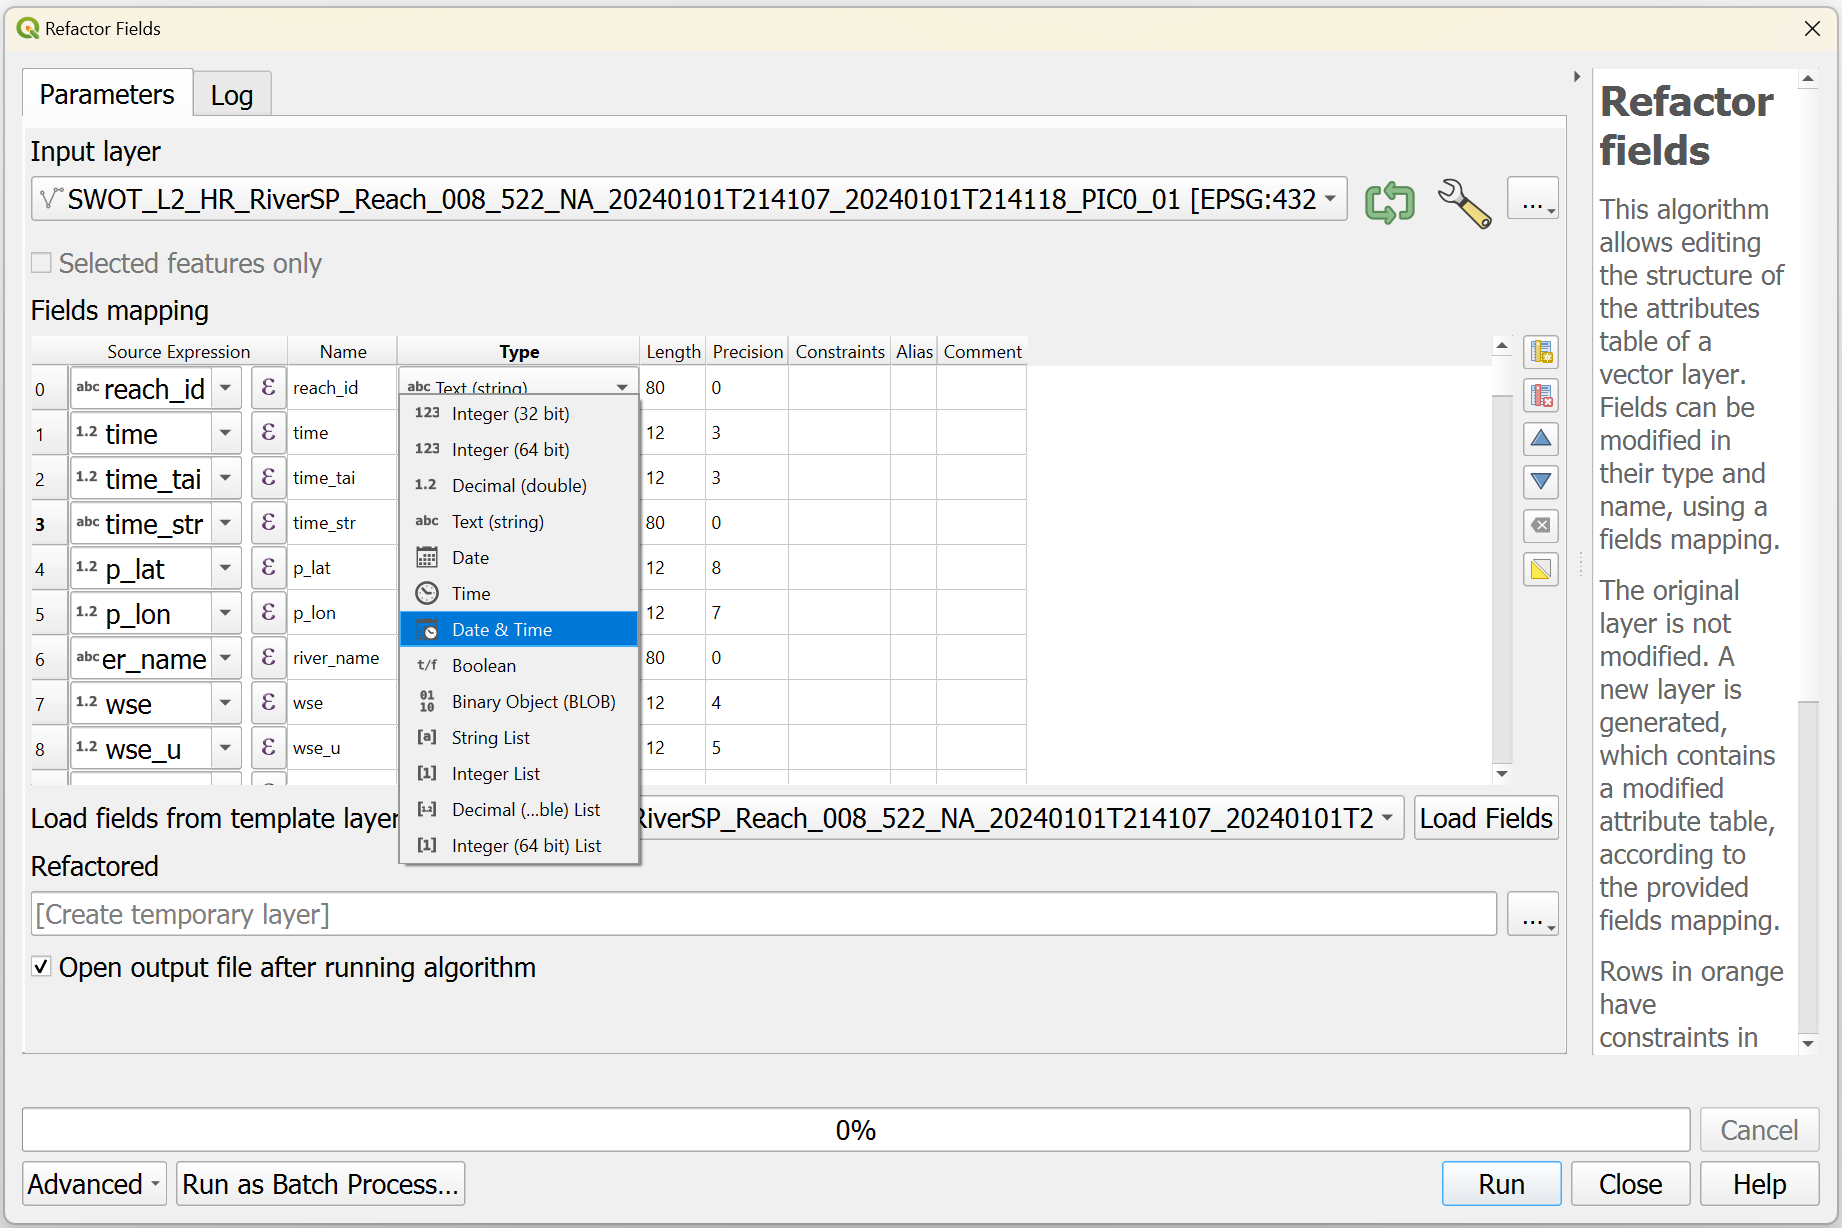

The new layer created does not include the 'no_data' values.

As shown in the image below; the black symbology is the original layer and the red symbology is the newly created layer without the 'no_data' values.

<nop/> <div style="width: 400px;">![qgis_datetime_3.png](../../images/swot_datetime/qgis_datetime_3.png)</div>
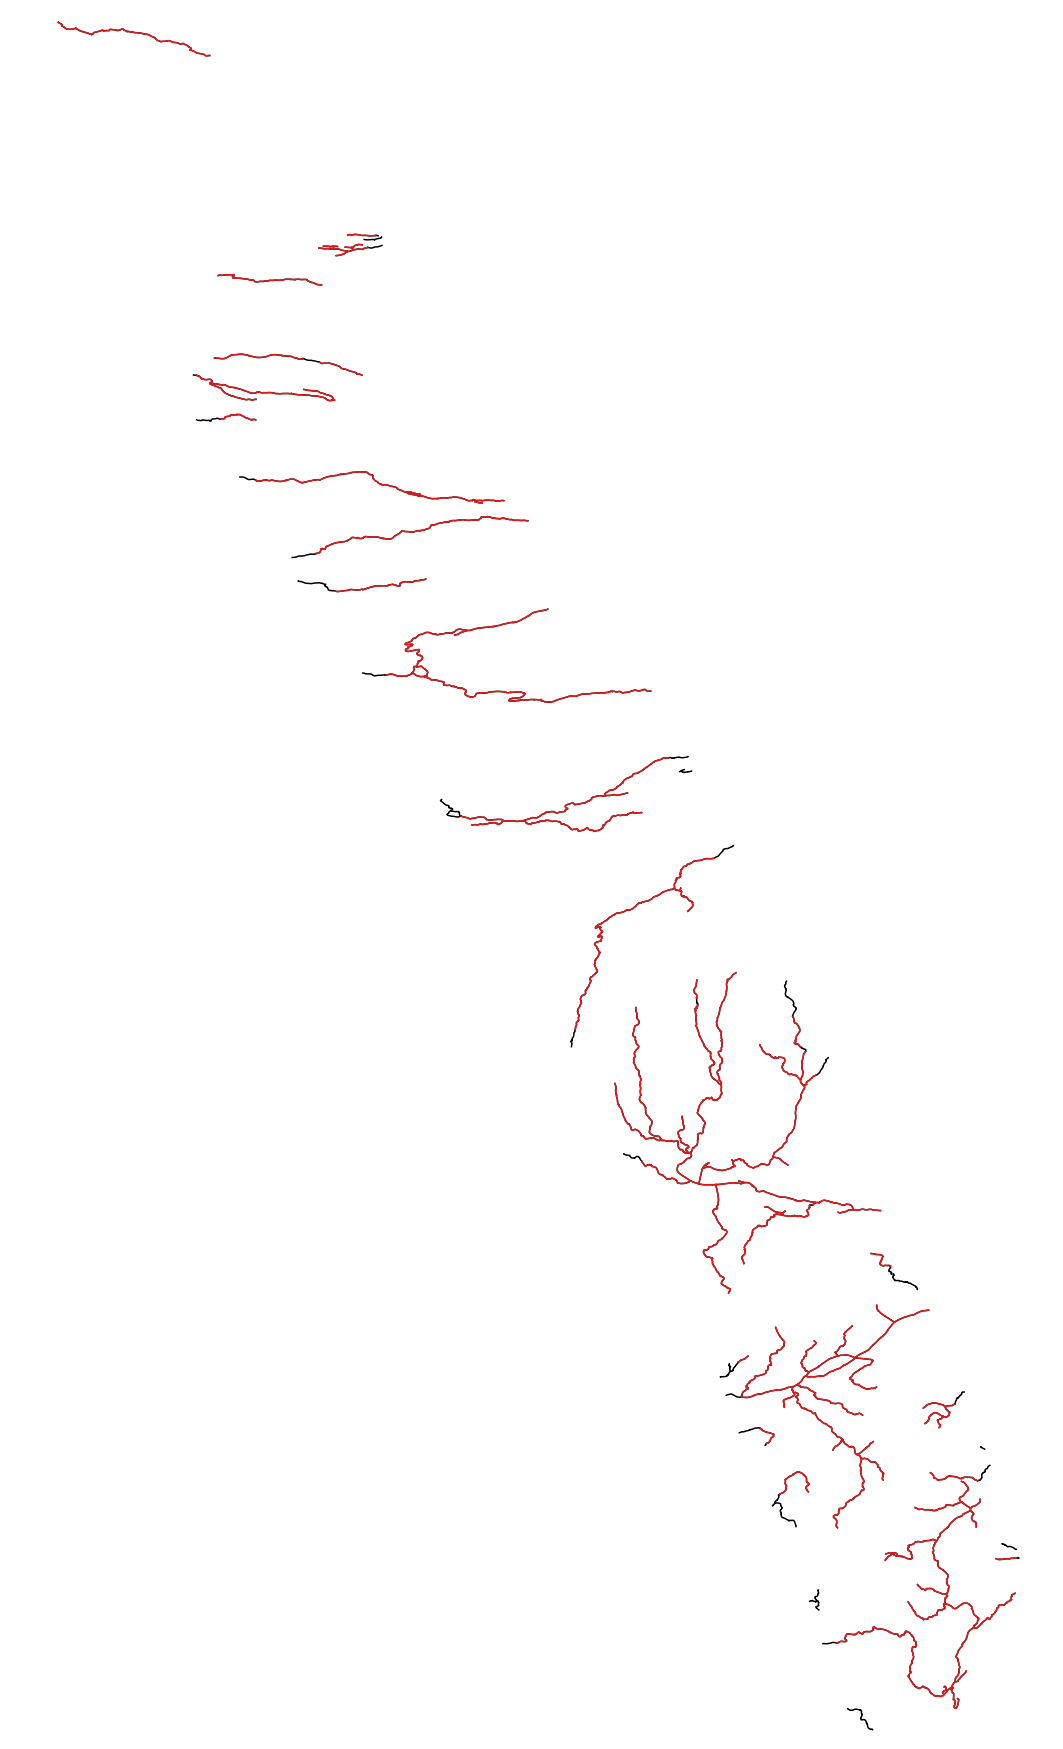

Within the processing toolbox, to create a time series select the 'Plots' category to show the various ways of plotting data.

<nop/> <div style="width: 400px;">![qgis_datetime_4.PNG](../../images/swot_datetime/qgis_datetime_4.PNG)</div>
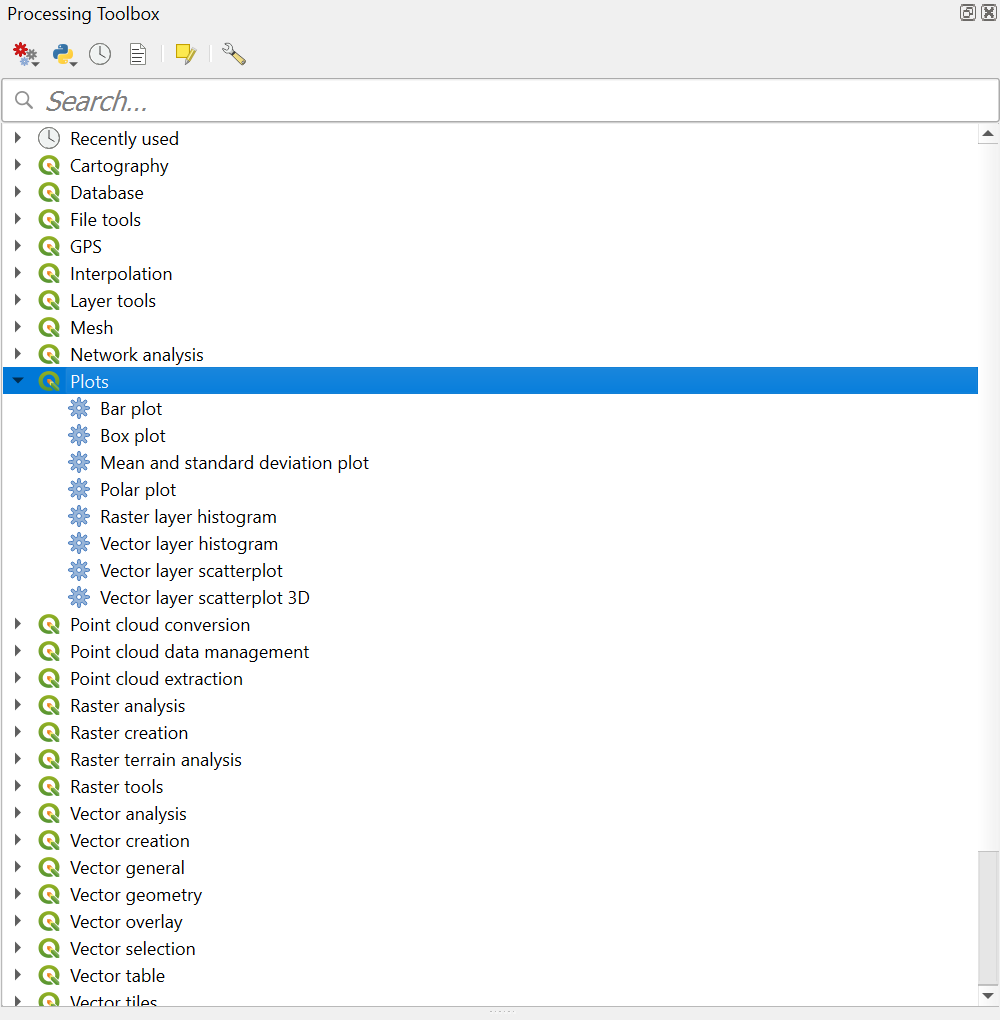

There also is the option of using the plugin [DataPlotly](https://dataplotly-docs.readthedocs.io/en/latest/intro.html), which utilizes the python library Plotly.

This offers a variety of ways to plot and customize your charts.

For this example, we will configure a box plot looking at both time and 'wse'. Also, querying 'wse' to only include values greater than 0, so it does not include any negative values.

<nop/> <div style="width: 600px;">![qgis_datetime_5.png](../../images/swot_datetime/qgis_datetime_5.png)</div>
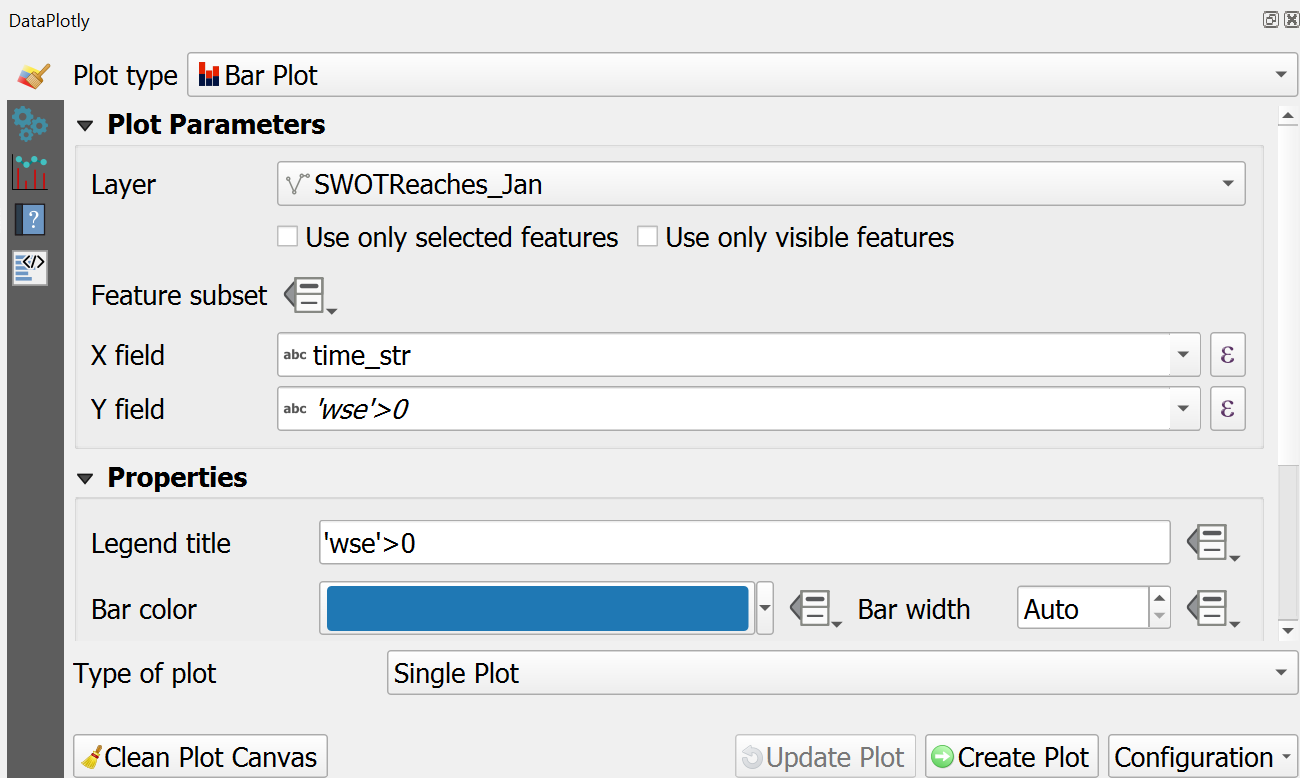

This plot showcases the data without the date/time transformation for a single month.

<nop/> <div style="width: 700px;">![qgis_datetime_6.png](../../images/swot_datetime/qgis_datetime_6.png)</div>

This plot is the same single month dataset but with the date/time transformation.

<nop/> <div style="width: 700px;">![qgis_datetime_7.png](../../images/swot_datetime/qgis_datetime_7.png)</div>

This plot showcases a single pass river reach as the same transformed image from above.

<nop/> <div style="width: 700px;">![qgis_datetime_8.png](../../images/swot_datetime/qgis_datetime_8.png)</div>
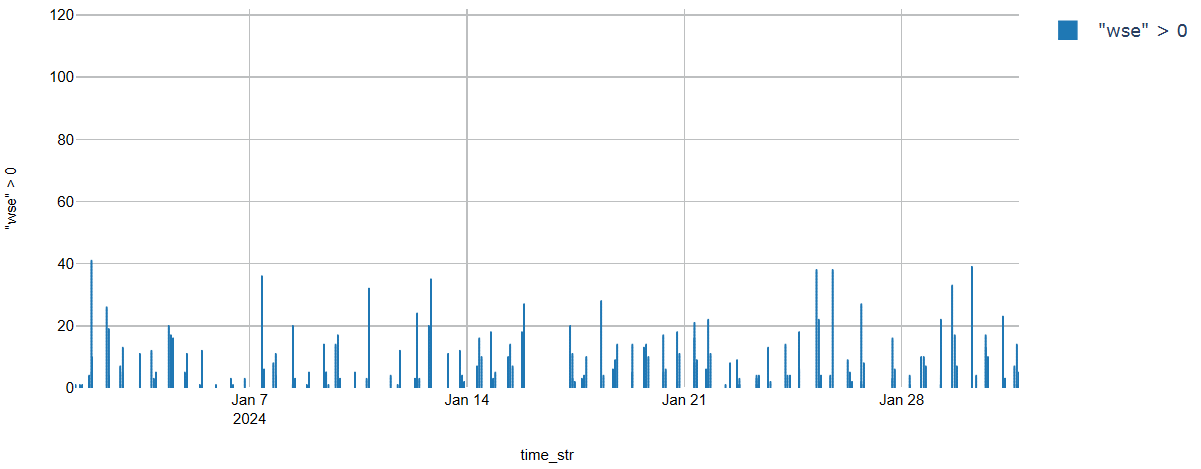
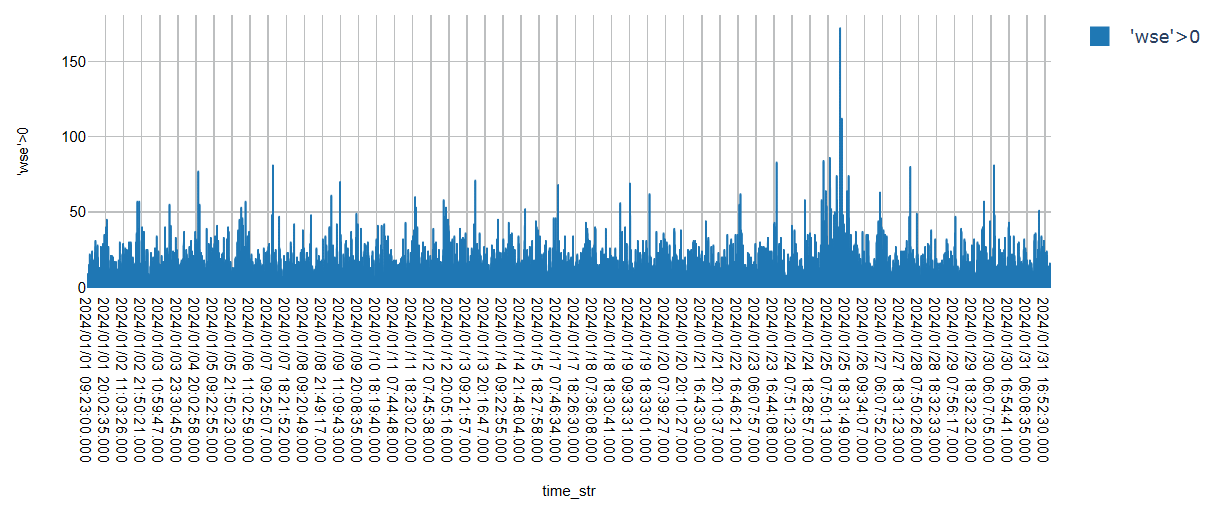
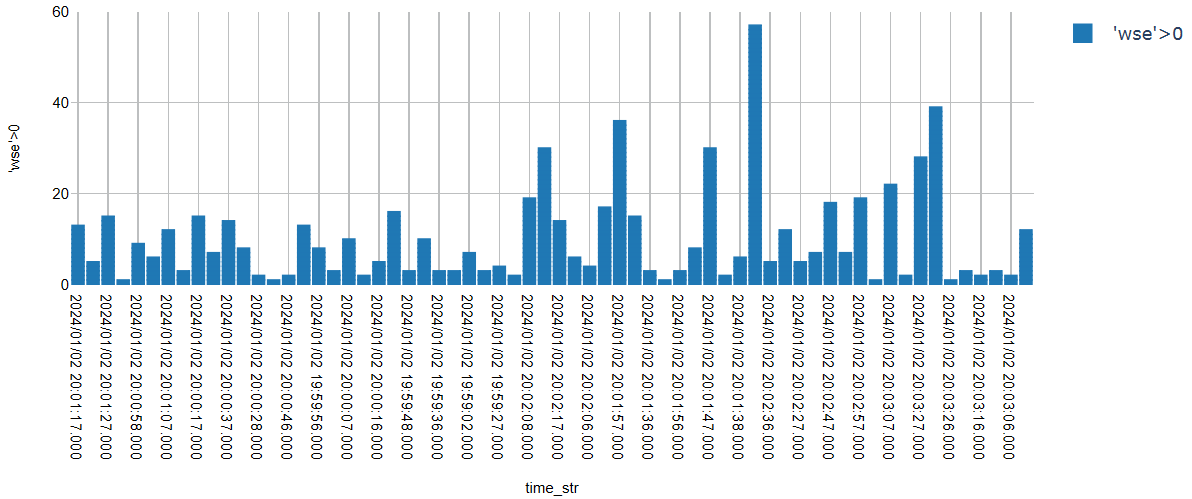